# Images

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import cv2

%matplotlib inline 
import keras
import theano
from tqdm import tqdm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier as gbc
from keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import fbeta_score


import tensorflow as tf
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os

def import_images(dir_path,n):
    list_of_images=[]
    if n >=1:
        for j in range(0,n):
            filename = dir_path + "/train_" + str(j) + ".jpg"
            image = mpimg.imread(filename)
            list_of_images.append(image)
        return list_of_images
    
dir_path='D:\\Data Science/train-jpg/'
n=100
images=import_images(dir_path,100)  

def create_batches(batch_size,n):
    list_of_images=[]
    while (True):
        for i in range(0,n):
            filename = dir_path + "/train_" + str(i) + ".jpg"
            image = mpimg.imread(filename)
            list_of_images.append(image)   
        
        for i in range(0,n,batch_size):       
            yield(list_of_images[i:i+batch_size],train_labels[i:i+batch_size].iloc[:,2:])

Using TensorFlow backend.
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


In [27]:
os.getcwd()

'D:\\Data Science'

# Labels

In [2]:
#import shit
import pandas as pd
train_labels=pd.read_csv('train_v2.csv')

#make list o' labels
labels=train_labels['tags'].str.split(' ')
label_values=[]
for row in labels.values:
    for label in row:
        if label not in label_values:
            label_values.append(label)
            
#make label dataframe
for label in label_values:
    train_labels[label] = train_labels['tags'].apply(lambda x: 1 if label in x.split(' ') else 0)
label_df=train_labels.iloc[:,2:]   

FileNotFoundError: File b'train_v2.csv' does not exist

In [ ]:
label_df

# EDA

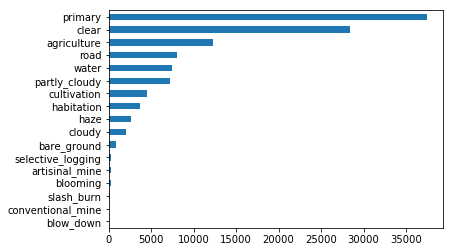

In [185]:
label_df.sum().sort_values(ascending=True).plot(kind='barh')

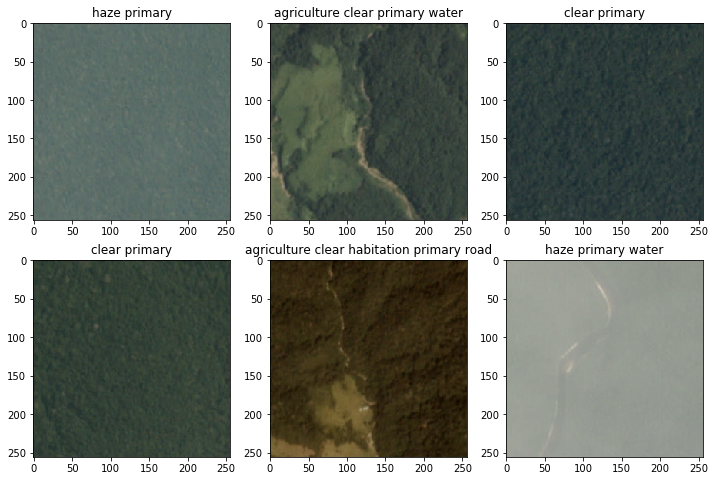

In [184]:
df_train_data = pd.read_csv('train_v2.csv')
df_train = df_train_data
filenames=[]
df_train_data = pd.read_csv('train_v2.csv')
df_train = df_train_data
plt.figure(figsize=(12,8))
for j in range(0,6):
    filename = dir_path + "/train_" + str(j) + ".jpg"
    plt.subplot(2,3,j+1)
    plt.imshow(plt.imread(filename))
    plt.title(str(df_train.tags[j]))

# Preparing the data

In [3]:
df_train_data = pd.read_csv('train_v2.csv')
df_train = df_train_data

flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train_data['tags'].values])))
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [21]:
#NEW CODE
x_train=[]
y_train=[]
for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    x_train.append(cv2.resize(img, (36, 36)))
    y_train.append(targets)
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16) / 255.

TypeError: 'module' object is not callable

In [164]:
valid_data_size = 5000  # Samples to withhold for validation
x_valid= x_train[(len(x_train) - valid_data_size):]
x_train = x_train[:(len(x_train) - valid_data_size)]
y_valid= y_train[(len(y_train) - valid_data_size):]
y_train = y_train[:(len(y_train) - valid_data_size)]
y_valid = np.array(y_valid, np.uint8)
x_valid = np.array(x_valid, np.float32)
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32)
x_test = np.array(x_test, np.float32)

In [ ]:
x_test1 = []
x_test2 = []

for f, tags in tqdm(df_test_data.values, miniters=1000):
    img = cv2.resize(cv2.imread('test-jpg/{}.jpg'.format(f)), (input_size, input_size))
    x_test1.append(img)
x_test1 = np.array(x_test, np.float32)

for f in range(20522):
    img = cv2.resize(cv2.imread('test-jpg-additional/file_'+str(f)+'.jpg'), (input_size, input_size))
    x_test2.append(img)
x_test2 = np.array(x_test2, np.float32)

x_test=np.concatenate((x_test1,x_test2),axis=0)

In [236]:
df_train_data = pd.read_csv('train_v2.csv')
flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train_data['tags'].values])))
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

# Un-tuned Convolutional Neural Network

In [168]:
epochs = 15
batch_size = 128
learning_rate = 0.001
lr_decay = 1e-4
input_size = 36
input_channels = 3

model = Sequential()
model.add(BatchNormalization(input_shape=(input_size, input_size, input_channels)))
model.add(Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu',input_shape ))
model.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(2, 2), padding='same', activation='relu'))
model.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(2, 2), padding='same', activation='relu'))
model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(2, 2), padding='same', activation='relu'))
model.add(Conv2D(256, kernel_size=(2, 2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

In [169]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=0),
             TensorBoard(log_dir='logs'),
             ModelCheckpoint('weights.h5',
                             save_best_only=True)]

opt = Adam(lr=learning_rate, decay=lr_decay)

model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          callbacks=callbacks,
          validation_data=(x_valid, y_valid))

p_valid = model.predict(x_valid, batch_size=batch_size)
print(fbeta_score(y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))

Train on 156916 samples, validate on 5000 samples
Epoch 1/15
545s - loss: 0.1745 - acc: 0.9320 - val_loss: 0.1301 - val_acc: 0.9494
Epoch 2/15
523s - loss: 0.1340 - acc: 0.9473 - val_loss: 0.1207 - val_acc: 0.9529
Epoch 3/15
503s - loss: 0.1251 - acc: 0.9511 - val_loss: 0.1133 - val_acc: 0.9561
Epoch 4/15
503s - loss: 0.1201 - acc: 0.9534 - val_loss: 0.1126 - val_acc: 0.9571
Epoch 5/15
503s - loss: 0.1163 - acc: 0.9549 - val_loss: 0.1088 - val_acc: 0.9580
Epoch 6/15
503s - loss: 0.1133 - acc: 0.9560 - val_loss: 0.1052 - val_acc: 0.9582
Epoch 7/15
502s - loss: 0.1113 - acc: 0.9567 - val_loss: 0.1045 - val_acc: 0.9594
Epoch 8/15
505s - loss: 0.1094 - acc: 0.9575 - val_loss: 0.1035 - val_acc: 0.9600
Epoch 9/15
503s - loss: 0.1077 - acc: 0.9581 - val_loss: 0.1022 - val_acc: 0.9596
Epoch 10/15
503s - loss: 0.1064 - acc: 0.9586 - val_loss: 0.1023 - val_acc: 0.9609
Epoch 11/15
502s - loss: 0.1053 - acc: 0.9591 - val_loss: 0.1003 - val_acc: 0.9608
Epoch 12/15
502s - loss: 0.1040 - acc: 0.9595 

NameError: name 'fbeta_score' is not defined

In [220]:
print(fbeta_score(y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))

0.911829377569


In [232]:
x_test=[]
for f, tags in tqdm(df_test_data.values, miniters=1000):
    img = cv2.resize(cv2.imread('test-jpg/{}.jpg'.format(f)), (input_size, input_size))
    x_test.append(img)
x_test = np.array(x_test, np.float32)    


100%|███████████████████████████████████| 61191/61191 [01:28<00:00, 687.82it/s]


In [ ]:
y_test = []
p_test = model.predict(x_test, batch_size=batch_size, verbose=2)
y_test.append(p_test)

from tqdm import tqdm
result = np.array(y_test[0])
result = pd.DataFrame(result, columns=labels)

preds = []

for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.ix[[i]]
    a = a.apply(lambda x: x > 0.2, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

In [240]:
df_test_data = pd.read_csv('sample_submission_v2.csv')
df_test_data['tags'] = preds
df_test_data.to_csv('submission.csv', index=False)

# Gradient Boosted Machines

In [3]:
def extract_features(df, data_path):
    im_features = df.copy()

    r_mean = []
    g_mean = []
    b_mean = []

    r_std = []
    g_std = []
    b_std = []

    r_max = []
    g_max = []
    b_max = []

    r_min = []
    g_min = []
    b_min = []

    r_kurtosis = []
    g_kurtosis = []
    b_kurtosis = []
    
    r_skewness = []
    g_skewness = []
    b_skewness = []

    for image_name in tqdm(im_features.image_name.values, miniters=100): 
        im = Image.open(data_path + image_name + '.jpg')
        im = np.array(im)[:,:,:3]

        r_mean.append(np.mean(im[:,:,0].ravel()))
        g_mean.append(np.mean(im[:,:,1].ravel()))
        b_mean.append(np.mean(im[:,:,2].ravel()))

        r_std.append(np.std(im[:,:,0].ravel()))
        g_std.append(np.std(im[:,:,1].ravel()))
        b_std.append(np.std(im[:,:,2].ravel()))

        r_max.append(np.max(im[:,:,0].ravel()))
        g_max.append(np.max(im[:,:,1].ravel()))
        b_max.append(np.max(im[:,:,2].ravel()))

        r_min.append(np.min(im[:,:,0].ravel()))
        g_min.append(np.min(im[:,:,1].ravel()))
        b_min.append(np.min(im[:,:,2].ravel()))

        r_kurtosis.append(scipy.stats.kurtosis(im[:,:,0].ravel()))
        g_kurtosis.append(scipy.stats.kurtosis(im[:,:,1].ravel()))
        b_kurtosis.append(scipy.stats.kurtosis(im[:,:,2].ravel()))
        
        r_skewness.append(scipy.stats.skew(im[:,:,0].ravel()))
        g_skewness.append(scipy.stats.skew(im[:,:,1].ravel()))
        b_skewness.append(scipy.stats.skew(im[:,:,2].ravel()))

    im_features['r_mean'] = r_mean
    im_features['g_mean'] = g_mean
    im_features['b_mean'] = b_mean

    im_features['r_std'] = r_std
    im_features['g_std'] = g_std
    im_features['b_std'] = b_std

    im_features['r_max'] = r_max
    im_features['g_max'] = g_max
    im_features['b_max'] = b_max

    im_features['r_min'] = r_min
    im_features['g_min'] = g_min
    im_features['b_min'] = b_min

    im_features['r_kurtosis'] = r_kurtosis
    im_features['g_kurtosis'] = g_kurtosis
    im_features['b_kurtosis'] = b_kurtosis
    
    im_features['r_skewness'] = r_skewness
    im_features['g_skewness'] = g_skewness
    im_features['b_skewness'] = b_skewness
    
    return im_features

In [6]:
df_train_data = pd.read_csv('train_v2.csv')
df_train = df_train_data

flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train_data['tags'].values])))
label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

In [7]:
x=[]
for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('D:\\Data Science/train-jpg/{}.jpg'.format(f))
    x.append(cv2.resize(img, (36, 36)))

100%|███████████████████████████████████| 40479/40479 [06:10<00:00, 109.24it/s]                                                                               


In [9]:
df_test_data = pd.read_csv('sample_submission_v2.csv')
x_test_gb=[]
for f, tags in tqdm(df_test_data.values, miniters=1000):
    img = cv2.imread('test-jpg/{}.jpg'.format(f))
    x_test_gb.append(cv2.resize(img, (36, 36)))
x_test_gb = np.array(x_test_gb, np.float32)

100%|███████████████████████████████████| 61191/61191 [07:56<00:00, 128.42it/s]                                                                               


In [11]:
#NEW CODE

y_train=[]
for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.imread('train-jpg/{}.jpg'.format(f))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    y_train.append(targets)
y_train = np.array(y_train, np.uint8)

100%|███████████████████████████████████| 40479/40479 [00:51<00:00, 790.14it/s]


In [25]:
y=y_train
x=np.asarray(x)
random_seed=1
n_classes = y.shape[1]

In [46]:
import numpy as np
import os
import pandas as pd
import random
from tqdm import tqdm


import scipy
from sklearn.metrics import fbeta_score
from PIL import Image


In [50]:
# Extract features
train_path = 'D:\\Data Science/train-jpg/'
test_path = 'D:\\Data Science/test-jpg/'
train = pd.read_csv('train_v2.csv')
test = pd.read_csv('sample_submission_v2.csv')


print('Extracting train features')
train_features = extract_features(train, train_path)
print('Extracting test features')
test_features = extract_features(test, test_path)

Extracting train features


100%|███████████████████████████████████| 40479/40479 [06:04<00:00, 110.98it/s]


Extracting test features


100%|███████████████████████████████████| 61191/61191 [09:11<00:00, 110.87it/s]


In [52]:
X = np.array(train_features.drop(['image_name', 'tags'], axis=1))
y_train = []

flatten = lambda l: [item for sublist in l for item in sublist]
labels = np.array(list(set(flatten([l.split(' ') for l in train_features['tags'].values]))))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

for tags in tqdm(train.tags.values, miniters=1000):
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1 
    y_train.append(targets)
    
y = np.array(y_train, np.uint8)

print('X.shape = ' + str(X.shape))
print('y.shape = ' + str(y.shape))

n_classes = y.shape[1]

X_test = np.array(test_features.drop(['image_name', 'tags'], axis=1))


100%|████████████████████████████████| 40479/40479 [00:00<00:00, 204846.93it/s]


X.shape = (40479, 18)
y.shape = (40479, 17)


In [82]:
valid_data_size = 5000  # Samples to withhold for validation
x_valid= X[(len(X) - valid_data_size):]
x_train = X[:(len(X) - valid_data_size)]
y_valid= y[(len(y) - valid_data_size):]
y_train = y[:(len(y) - valid_data_size)]
y_valid = np.array(y_valid, np.uint8)
x_valid = np.array(x_valid, np.float32)
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32)

In [88]:
y_pred = np.zeros((x_valid.shape[0], n_classes))

In [89]:
#ORIGINAL CODE
for class_i in tqdm(range(n_classes), miniters=1): 
    model = gbc(max_depth=5, learning_rate=0.1, n_estimators=100)
    model.fit(x_train, y_train[:, class_i])
    
    y_pred[:, class_i] = model.predict_proba(x_valid)[:, 1]
p_valid = [' '.join(labels[y_pred_row > 0.21]) for y_pred_row in y_pred]

  0%|                                                   | 0/17 [00:00<?, ?it/s]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

  6%|██▌                                        | 1/17 [00:08<02:19,  8.71s/it]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

 12%|█████                                      | 2/17 [00:17<02:10,  8.68s/it]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

 18%|███████▌                                   | 3/17 [00:26<02:03,  8.85s/it]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

 24%|██████████                                 | 4/17 [00:35<01:56,  8.98s/it]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

 29%|████████████▋                              | 5/17 [00:44<01:45,  8.77s/it]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

 35%|███████████████▏                           | 6/17 [00:52<01:35,  8.69s/it]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

 41%|█████████████████▋                         | 7/17 [01:01<01:27,  8.78s/it]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

 47%|████████████████████▏                      | 8/17 [01:10<01:19,  8.81s/it]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

 53%|██████████████████████▊                    | 9/17 [01:19<01:11,  8.97s/it]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

 59%|████████████████████████▋                 | 10/17 [01:29<01:03,  9.05s/it]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

 65%|███████████████████████████▏              | 11/17 [01:37<00:53,  8.94s/it]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

 71%|█████████████████████████████▋            | 12/17 [01:45<00:43,  8.60s/it]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

 76%|████████████████████████████████          | 13/17 [01:54<00:34,  8.71s/it]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

 82%|██████████████████████████████████▌       | 14/17 [02:03<00:26,  8.86s/it]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

 88%|█████████████████████████████████████     | 15/17 [02:12<00:17,  8.74s/it]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

 94%|███████████████████████████████████████▌  | 16/17 [02:20<00:08,  8.59s/it]

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

100%|██████████████████████████████████████████| 17/17 [02:28<00:00,  8.57s/it]


In [94]:
print(fbeta_score(y_valid, np.array(y_pred) > 0.2, beta=2, average='samples'))

0.880423797452


In [146]:
len(x_train)

35479

In [172]:
label_df.columns

Index(['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation',
       'road', 'cultivation', 'slash_burn', 'cloudy', 'partly_cloudy',
       'conventional_mine', 'bare_ground', 'artisinal_mine', 'blooming',
       'selective_logging', 'blow_down'],
      dtype='object')

In [183]:
train_features[train_features.tags.str.contains('artisinal_mine')][['r_mean','g_mean','b_mean']].mean()
train_features[train_features.tags.str.contains('slash_burn')][['r_mean','g_mean','b_mean']].mean()
train_features[train_features.tags.str.contains('conventional_mine')][['r_mean','g_mean','b_mean']].mean()
train_features[train_features.tags.str.contains('selective_logging')][['r_mean','g_mean','b_mean']].mean()
train_features[train_features.tags.str.contains('agriculture')][['r_mean','g_mean','b_mean']].mean()
train_features[train_features.tags.str.contains('cultivation')][['r_mean','g_mean','b_mean']].mean()

r_mean    138.559516
g_mean    144.413697
b_mean    166.975032
dtype: float64

r_mean    186.843740
g_mean    178.051002
b_mean    189.023008
dtype: float64

r_mean    140.931125
g_mean    151.955816
b_mean    167.966960
dtype: float64

r_mean    199.092710
g_mean    189.420334
b_mean    198.958433
dtype: float64

r_mean    163.337318
g_mean    159.879923
b_mean    173.723920
dtype: float64

r_mean    181.001937
g_mean    172.985986
b_mean    184.288951
dtype: float64

# Unused code

# Tuning Batch Size and Number of Epochs

In [ ]:
seed = 1
np.random.seed(seed)
model = KerasClassifier(build_fn=create_model, epochs=10)

batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(x_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Epoch 1/10
Epoch 1/10
Epoch 1/10
Epoch 1/50


In [ ]:
model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))
          
from sklearn.metrics import fbeta_score

p_valid = model.predict(x_test, batch_size=128)
print(y_test)
print(p_valid)
print(fbeta_score(y_test, np.array(p_valid) > 0.07, beta=1, average='samples'))

In [172]:
fbeta_score(y_test, np.array(p_valid) > 0.067, beta=1, average='samples')

0.52870069930069941

# Training data

In [63]:
n_train=40479

def training_data(n):
    x_train=np.asarray(import_images(dir_path,n))
    y_train=np.asarray(label_df.iloc[:n,:])
    return x_train, y_train

x_train = training_data(n_train)[0] #numpy array of 100 images
x_train = np.asarray([cv2.resize(x_train[j],(36,36)) for j in range(0,len(x_train))])

y_train = training_data(n_train)[1]
x_train.shape, y_train.shape
x_train.dtype, y_train.dtype

x_train = x_train.astype('float32')
x_train/=255

((40479, 36, 36, 4), (40479, 17))

(dtype('uint8'), dtype('int64'))

In [66]:
#pickle the training data
import pickle as pkl
output = open('x_train.pkl', 'wb')
pkl.dump(x_train, output)   

In [112]:
#import the training data
import pickle
x_train = pickle.load( open( "x_train.pkl", "rb" ) )
y_train=np.asarray(label_df)

In [114]:
x_train*=255

# Old preparation code

In [ ]:
# OLD CODE
x_train=[]
y_train=[]

for f, tags in tqdm(df_train.values, miniters=1000):
    img = cv2.resize(cv2.imread('train-jpg/{}.jpg'.format(f)), (input_size, input_size))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    x_train.append(img)
    y_train.append(targets)
    img = cv2.flip(img, 0)  # flip vertically
    x_train.append(img)
    y_train.append(targets)
    img = cv2.flip(img, 1)  # flip horizontally
    x_train.append(img)
    y_train.append(targets)
    img = cv2.flip(img, 0)  # flip vertically
    x_train.append(img)
    y_train.append(targets)
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32)

# Testing Data

In [82]:
def import_images2(dir_path,n):
    list_of_images=[]
    if n >=1:
        for j in range(0,n):
            filename = dir_path + "/test_" + str(j) + ".jpg"
            image = mpimg.imread(filename)
            list_of_images.append(image)
        return list_of_images

def import_images3(dir_path,n):
    list_of_images=[]
    if n >=1:
        for j in range(0,n):
            filename = dir_path + "/file_" + str(j) + ".jpg"
            image = mpimg.imread(filename)
            list_of_images.append(image)
        return list_of_images    


x_test1=np.asarray(import_images2('D:\\Data Science/test-jpg/',40669))
x_test2=np.asarray(import_images3('D:\\Data Science/test-jpg-additional/',20522))
x_test1 = np.asarray([cv2.resize(x_test1[j],(36,36)) for j in range(0,len(x_test1))])
x_test2 = np.asarray([cv2.resize(x_test2[j],(36,36)) for j in range(0,len(x_test2))])

x_test1 = x_test1.astype('float32')
x_test2 = x_test2.astype('float32')
x_test1/=255
x_test2/=255

In [85]:
#pickle the testing data
import pickle as pkl
output = open('x_test1.pkl', 'wb')
pkl.dump(x_test1, output)   

output = open('x_test2.pkl', 'wb')
pkl.dump(x_test2, output)   

In [86]:
#import the testing data
import pickle
x_test1 = pickle.load( open( "x_test1.pkl", "rb" ) )
x_test2 = pickle.load( open( "x_test2.pkl", "rb" ) )
x_test=np.concatenate((x_test1,x_test2),axis=0)
x_test.shape

(61191, 36, 36, 4)

# Tuned Convolutional Neural Network

In [242]:
#changed learning algorithm from Adam to SGD
#5-fold cross validation

In [304]:
epochs = 15
batch_size = 128
learning_rate = 0.001
lr_decay = 1e-4
input_size = 36
input_channels = 3

def create_model():
    model = Sequential()
    model.add(BatchNormalization(input_shape=(input_size, input_size, input_channels)))
    model.add(Conv2D(32, kernel_size=(2, 2), padding='same', activation='relu'))
    model.add(Conv2D(32, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(2, 2), padding='same', activation='relu'))
    model.add(Conv2D(64, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(2, 2), padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, kernel_size=(2, 2), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
    return model

In [300]:
subset=np.random.choice(range(len(x_train)),size=5000,replace=False)
x_train_subset=x_train[subset]
y_train_subset=y_train[subset]

In [ ]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=0),
             TensorBoard(log_dir='logs'),
             ModelCheckpoint('weights.h5',
                             save_best_only=True)]

opt = SGD(lr=learning_rate, decay=lr_decay)



model = KerasClassifier(build_fn=create_model, verbose=0)
seed = 7
np.random.seed(seed)
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(x_train_subset,y_train_subset)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          callbacks=callbacks,
          validation_data=(x_valid, y_valid))

p_valid = model.predict(x_valid, batch_size=batch_size)
print(fbeta_score(y_valid, np.array(p_valid) > 0.2, beta=2, average='samples'))

# Convolutional Neural Network

Train on 40479 samples, validate on 4000 samples
Epoch 1/2
40479/40479 [==============================] - 48s - loss: 0.3500 - acc: 0.8317 - val_loss: 0.3353 - val_acc: 0.8321
Epoch 2/2
40479/40479 [==============================] - 47s - loss: 0.3308 - acc: 0.8336 - val_loss: 0.3317 - val_acc: 0.8325


Test loss: 0.333182020803
Test accuracy: 0.832183115191


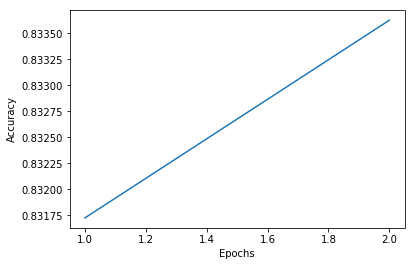

In [23]:
class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()
#input_shape = (256,256,4)
input_shape = (36,36,4)
num_classes=len(label_df.columns)
batch_size = 200
epochs = 2

model = Sequential()
model.add(Conv2D(32, kernel_size=(4, 4), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu')) #64 before
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu')) #1000 before
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[history])
score = model.evaluate(x_train, y_train, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, 3), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Convolutional Neural Network 2


In [55]:
np.random.seed(123)  # for reproducibility

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(36, 36, 4))) 

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='sigmoid'))

model.compile(loss='binary_crossentropy', # We NEED binary here, since categorical_crossentropy l1 norms the output before calculating loss.
              optimizer='adam',
              metrics=['accuracy'])
              
model.fit(x_train, y_train,
          batch_size=128,
          epochs=4,
          verbose=1,
          validation_data=(x_test, y_test))
          
from sklearn.metrics import fbeta_score

p_valid = model.predict(x_test, batch_size=128)
print(y_test)
print(p_valid)
print(fbeta_score(y_test, np.array(p_valid) > 0.2, beta=2, average='samples'))

Train on 1000 samples, validate on 1000 samples
Epoch 1/4
1000/1000 [==============================] - 4s - loss: 0.4331 - acc: 0.8006 - val_loss: 0.6837 - val_acc: 0.9060
Epoch 2/4
1000/1000 [==============================] - 4s - loss: 0.3253 - acc: 0.8799 - val_loss: 0.6683 - val_acc: 0.9060
Epoch 3/4
1000/1000 [==============================] - 3s - loss: 0.3008 - acc: 0.8828 - val_loss: 0.6725 - val_acc: 0.9060
Epoch 4/4
1000/1000 [==============================] - 3s - loss: 0.2841 - acc: 0.8942 - val_loss: 0.6724 - val_acc: 0.9060


[[1 1 0 ..., 0 0 0]
 [0 1 1 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 ..., 
 [0 1 0 ..., 0 1 0]
 [0 1 1 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]]
[[ 0.48530594  0.51725465  0.49335709 ...,  0.48797077  0.48610291
   0.48660642]
 [ 0.4847056   0.5181455   0.49295655 ...,  0.48761269  0.48546579
   0.48620266]
 [ 0.48438144  0.51854843  0.49273649 ...,  0.48742038  0.48514348
   0.48599094]
 ..., 
 [ 0.48557791  0.51687098  0.49359265 ...,  0.48808038  0.48637834
   0.48673585]
 [ 0.48560899  0.51680231  0.4935973  ...,  0.48814046  0.48641804
   0.4868024 ]
 [ 0.48481631  0.51796788  0.49304301 ...,  0.4876788   0.48558483
   0.48627418]]
0.484113458853


# Convolutional Network 3

In [40]:
#https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py
np.random.seed(123)  # for reproducibility

def create_model(): 
    model = KerasClassifier(build_fn=create_model)
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same',input_shape=(36, 36, 4)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))  
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [58]:
seed = 1
np.random.seed(seed)

#model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=100, verbose=1,validation_data=(x_test, y_test),
#                       callbacks=[history])
create_model().fit(x_train, y_train,
          batch_size=128,
          epochs=4,
          verbose=1,
          validation_data=(x_test, y_test))

p_valid = model.predict(x_test, batch_size=128)
print(y_test)
print(p_valid)
print(fbeta_score(y_test, np.array(p_valid) > 0.2, beta=2, average='samples'))

Train on 1000 samples, validate on 1000 samples
Epoch 1/4
1000/1000 [==============================] - 5s - loss: 0.4278 - acc: 0.8365 - val_loss: 0.5206 - val_acc: 0.8307
Epoch 2/4
1000/1000 [==============================] - 5s - loss: 0.3759 - acc: 0.8414 - val_loss: 0.5165 - val_acc: 0.8307
Epoch 3/4
1000/1000 [==============================] - 5s - loss: 0.3631 - acc: 0.8409 - val_loss: 0.5102 - val_acc: 0.8307
Epoch 4/4
1000/1000 [==============================] - 5s - loss: 0.3554 - acc: 0.8369 - val_loss: 0.5079 - val_acc: 0.8307


[[1 1 0 ..., 0 0 0]
 [0 1 1 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 ..., 
 [0 1 0 ..., 0 1 0]
 [0 1 1 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]]
[[ 0.48459858  0.52061588  0.49885014 ...,  0.47920898  0.47956112
   0.47932899]
 [ 0.48419741  0.52080125  0.49863994 ...,  0.47925273  0.47962457
   0.47956717]
 [ 0.48397484  0.52071077  0.49845749 ...,  0.47941083  0.47976795
   0.47981909]
 ..., 
 [ 0.48474655  0.52094764  0.49894604 ...,  0.47886622  0.47921374
   0.47897717]
 [ 0.48476195  0.52070189  0.49894461 ...,  0.47907791  0.47941095
   0.47917736]
 [ 0.48428017  0.52075052  0.49866971 ...,  0.4793056   0.47966155
   0.47957879]]
0.484113458853
